# 基于 YOLOv5 框架的物体检测

## 一. 初始化

In [1]:
import os
import sys
import random
import time
import math
import shutil

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
# 超参数
TEMP_RESULT_DIR = r'./temp' # 零时分割图结果保存根目录
TEMP_CLIP_DIR = r'./temp/clip' # 零时分割图

shutil.rmtree(TEMP_RESULT_DIR)
os.mkdir(TEMP_RESULT_DIR)

## 二. 预处理

### 2.1. 超分辨率分割

将原图像按照一定策略裁剪成模型指定的输入尺寸，预测完毕后，进行拼接

In [3]:
def get_up_left_coordinates(image, size=(5, 5), stride=(2, 2), padding="VALID"):
    """
    This op gets up-left-corner coordinates of patches in input images.
    
    Args:
        image: A numpy.ndarray with shape [in_rows, in_cols, depth], the input image
        size: A tuple or list like [size_rows, size_cols], The size of extracted patches;
        stride: A tuple or list like [stride_rows, stride_cols], How far the centers of 
            two consecutive patches are in the images;
        padding: String, "SAME" or "VALID"
        
    Returns:
        up_left_coordinates: A numpy.ndarray with shape [number_rows, number_cols, 2],
            e.x. [[[y1, x1]],[[y2, x2]]]
        
    """
    image_shape = image.shape
    
    if padding.upper() == "VALID":
        number_rows = (image_shape[0] - size[0]) // stride[0] + 1
        number_cols = (image_shape[1] - size[1]) // stride[1] + 1
    elif padding.upper() == "SAME":
        number_rows = image_shape[0] // stride[0] + 1
        number_cols = image_shape[1] // stride[1] + 1
    else:
        raise ValueError("padding MUST be 'SAME' or 'VALID'")
    
    rows_coordinates = np.arange(number_rows)
    cols_coordinates = np.arange(number_cols)
    rows_coordinates, cols_coordinates = np.meshgrid(rows_coordinates, cols_coordinates)
    
    up_left_coordinates = np.stack((rows_coordinates, cols_coordinates), axis=-1)
    up_left_coordinates = np.transpose(up_left_coordinates, (1, 0, 2))
    up_left_coordinates = up_left_coordinates * stride
    
    return up_left_coordinates

In [4]:
def pad_image(image, size=(5, 5), stride=(2, 2), padding="VALID"):
    """
    This op pads input images.
    
    Args:
        image: A numpy.ndarray with shape [in_rows, in_cols, depth], the input image
        size: A tuple or list like [size_rows, size_cols], The size of extracted patches;
        stride: A tuple or list like [stride_rows, stride_cols], How far the centers of 
            two consecutive patches are in the images;
        padding: String, "SAME" or "VALID"
        
    Returns:
        padding_image: numpy.ndarray, the images after padding
    """
    padding_image = image
    image_shape = image.shape
    
    if padding.upper() == "VALID":
        pass
    elif padding.upper() == "SAME":
        rows_padding_pixel = image_shape[0] // stride[0] * stride[0] + size[0] - image_shape[0]
        rows_padding_pixel = rows_padding_pixel if rows_padding_pixel > 0 else 0
        cols_padding_pixel = image_shape[1] // stride[1] * stride[1] + size[1] - image_shape[1]
        cols_padding_pixel = cols_padding_pixel if cols_padding_pixel > 0 else 0

        padding_image = np.pad(
            padding_image, 
            ((0, rows_padding_pixel),(0, cols_padding_pixel),(0, 0)),
            'constant',
            constant_values=(0, 0)
        )
    else:
        raise ValueError("padding MUST be 'SAME' or 'VALID'")
    
    return padding_image

In [5]:
def extract_image_patches(image, size=(10, 10), stride=(10, 10), rate=(1, 1), padding="VALID"):
    """
    This op collects patches from the input image, as if applying a convolution. 
    All extracted patches are stacked in the depth (last) dimension of the output.
    Specifically, the op extracts patches of shape sizes which are strides apart 
    in the input image. The output is subsampled using the rates argument, in the 
    same manner as "atrous" or "dilated" convolutions.
    
    Args:
        image: A numpy.ndarray with shape [in_rows, in_cols, depth];
        size: A tuple or list like [size_rows, size_cols], The size of extracted patches;
        stride: A tuple or list like [stride_rows, stride_cols], How far the centers of 
            two consecutive patches are in the images;
        rate: A tuple or list like [rate_rows, rate_cols]. This is the input stride, 
            specifying how far two consecutive patch samples are in the input. Equivalent 
            to extracting patches with 
            "patch_sizes_eff = patch_sizes + (patch_sizes - 1) * (rates - 1)", followed 
            by subsampling them spatially by a factor of rates. This is equivalent to rate in 
            dilated (a.k.a. Atrous) convolutions;
        padding: String, "SAME" or "VALID". The type of padding algorithm to use.The padding 
            argument has no effect on the size of each patch, it determines how many patches 
            are extracted. If VALID, only patches which are fully contained in the input image 
            are included. If SAME, all patches whose starting point is inside the input are 
            included, and areas outside the input default to zero.
            
    Returns:
        up_left_coordinates: A numpy.ndarray with shape [number_patches, 2], e.x. [[y1, x1],[y2, x2]]
        patches: A numpy.ndarray with shape [number_patches, size_rows, size_cols, depth];
    """
    
    assert len(size) == 2, "The length of size is not 2"
    assert len(stride) == 2, "The length of stride is not 2"
    assert len(rate) == 2, "The length of rate is not 2"
    assert padding.upper() in ["SAME", "VALID"], "padding MUST be 'SAME' or 'VALID'"
    
    size = (
        size[0] + (size[0] - 1) * (rate[0] - 1),
        size[1] + (size[1] - 1) * (rate[1] - 1),
    ) # update patch_size
    
    up_left_coordinates = get_up_left_coordinates(image, size, stride, padding)
    image = pad_image(image, size, stride, padding)
    
    patches = []
    for y, x in np.reshape(up_left_coordinates, (-1, 2)):
        patches.append(
            image[y:y+size[0], x:x+size[1]], 
        )
    patches = np.stack(patches, axis=0)
    patches = np.reshape(patches, list(up_left_coordinates.shape[:-1])+[-1])
    
    return up_left_coordinates, patches
    

### 2.2 读取图像

In [6]:
# 读入图片
image = cv2.imread('demo.jpg')
# image = np.random.random((5,5,1))

# 图片抽块
size = (500, 500)
stride = (300, 300)
up_left_coordinates, patches = extract_image_patches(image, size, stride, padding="same")

#print(f'image shape is {image.shape}')
#print(f'patches shape is {patches.shape}')

### 2.3 图像展示

Image size: 1920 X 2448
Patch size: 7 X 9
Patches per image: 63
Elements per patch: 750000


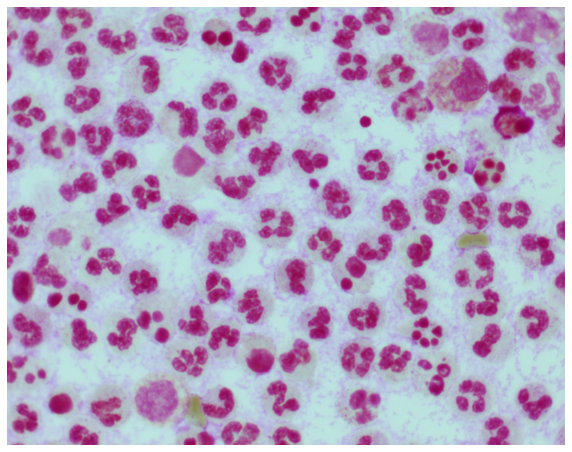

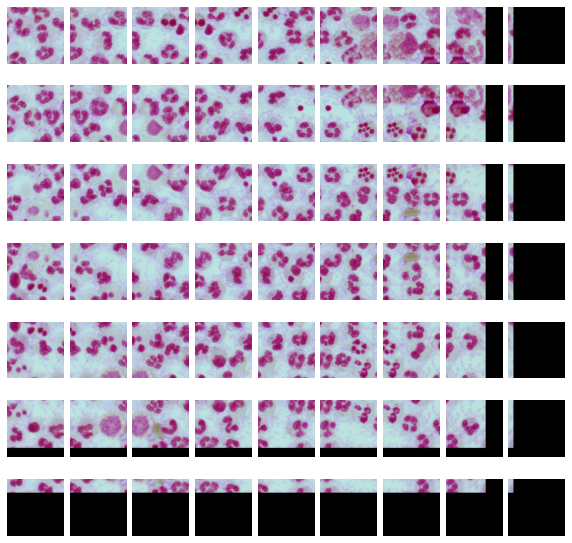

In [7]:
# 图片展示

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(image.astype("uint8"))
ax.set_axis_off()

number_rows, number_cols, elements = patches.shape
print(f"Image size: {image.shape[0]} X {image.shape[1]}")
print(f"Patch size: {number_rows} X {number_cols}")
print(f"Patches per image: {number_cols * number_rows}")
print(f"Elements per patch: {elements}")
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for row in range(number_rows):
    for col in range(number_cols):
        ax = plt.subplot(number_rows, number_cols, row * number_cols + col + 1)
        patch_image = np.reshape(patches[row, col], (size[0], size[1], -1))
        ax.imshow(patch_image.astype("uint8"))
        ax.set_axis_off()
#         ax.set_title(up_left_coordinates[row, col])

### 2.4 图像保存

In [8]:
# 保存小图
if not os.path.exists(TEMP_CLIP_DIR):
    os.mkdir(TEMP_CLIP_DIR)
    
for row in range(number_rows):
    for col in range(number_cols):
        y, x = up_left_coordinates[row, col]
        patch_image = np.reshape(patches[row, col], (size[0], size[1], -1))
        cv2.imwrite(
            os.path.join(TEMP_CLIP_DIR, f'{y}_{x}.png'), 
            patch_image.astype("uint8")
        )

## 三. 目标检测

In [9]:
# 目标检测
from detect import run

In [10]:
run(
    weights=r'runs/cell/baseline/weights/best.pt',
    source=TEMP_CLIP_DIR,
    data=r'data/cells.yaml',
#     conf_thres=0.1,
    save_txt=True,
    project=TEMP_RESULT_DIR,
    name='result',
)


YOLOv5  2022-4-25 torch 1.10.0 CUDA:0 (GeForce RTX 2060, 6144MiB)

Fusing layers... 
Model summary: 213 layers, 7023610 parameters, 0 gradients
image 1/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_0.png: 640x640 9 NEUs, Done. (0.012s)
image 2/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_1200.png: 640x640 7 NEUs, Done. (0.013s)
image 3/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_1500.png: 640x640 6 NEUs, Done. (0.012s)
image 4/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_1800.png: 640x640 4 NEUs, Done. (0.013s)
image 5/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_2100.png: 640x640 2 NEUs, 1 OTHER, Done. (0.013s)
image 6/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_2400.png: 640x640 Done. (0.013s)
image 7/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_300.png: 640x640 7 NEUs, Done. (0.012s)
image 8/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_600.png: 640x640 7 NEUs, Done. (0.013s)
image 9/63 C:\Users\luzhe\deep_learning\YOLOv5\temp\clip\0_9

## 四. 结果拼接

### 4.1 合并结果

In [11]:
# 读取结果
label_dir_path = os.path.join(TEMP_RESULT_DIR, 'result', 'labels')
files = [os.path.join(root, file) for root, dirs, files in os.walk(label_dir_path)
         for file in files if os.path.splitext(file)[1] == '.txt']
# files

In [12]:
# 解析标签
original_height,  original_width = image.shape[:2]
clip_height, clip_width = size[:2]
labels = []

for file in files:
    
    # 根据文件名解析图片左上角点在原图中的坐标
    file_name = os.path.split(file)[1] # e.g. 400_600.text
    file_name = os.path.splitext(file_name)[0] # e.g. 400_600
    y_lu, x_lu = list(map(int, file_name.split('_'))) # y=400, x=600
    
    
    with open(file, 'r') as f:
        lines = f.readlines()
    
    if len(lines) < 1:
        continue
        
    for line in lines:
        # 获取小图中结果信息
        class_id, x_center, y_center, width, height = list(
            map(
                float, 
                line.strip('\n').split())
        )
        
        # 将小图结果迁移到原始图像上
        class_id = int(class_id)
        x_center = (x_center * clip_width + x_lu) / original_width
        y_center = (y_center * clip_height + y_lu) / original_height
        width = width * clip_width / original_width
        height = height * clip_height / original_height
        
        # 追加到标签列表
        labels.append([class_id, x_center, y_center, width, height])

In [13]:
## 工具函数，修建输入值
def clip_value(x, xmin=0, xmax=1e5):
    if x <= xmin:
        x = xmin
    if x >= xmax:
        x = xmax - 1
    return x

In [14]:
# 可视化原始图像标签

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)

image_view_without_nms = image.copy()
for class_id, x_center, y_center, width, height in labels:

    x1 = int((x_center - width / 2) * original_width)
    x1 = clip_value(x1, 0, original_width)
    
    x2 = int((x_center + width / 2) * original_width)
    x2 = clip_value(x2, 0, original_width)
    
    y1 = int((y_center - height / 2) * original_height)
    y1 = clip_value(y1, 0, original_height)
    
    y2 = int((y_center + height / 2) * original_height)
    y2 = clip_value(y2, 0, original_height)

#     if line[0] == '0':
#         color = (0, 255, 0)
#     else:
#         color = (0, 0, 255)

    color = (0, 0, 255)
    cv2.rectangle(image_view_without_nms, (x1, y1), (x2, y2), color, 5)
    
# cv2.imshow('1', image_view)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# ax.imshow(cv2.cvtColor(image_view, cv2.COLOR_BGR2RGB).astype("uint8"))
# ax.set_axis_off()

In [15]:
# NMS 过滤 labels
def nms(boxes, area_threshold = 0.1, iou_threshold=0.99):
    """Executes Non-Maximum Suppression. We use areas as a threshold instead of predicted score.
    
    Args:
        boxes (ndarray): [N, (y1, x1, y2, x2)] detection bounding boxes
        area_threshold (Float): minimum of bounding_boxes areas
        iou_threshold (Float): maximum of IOU
    
    Return:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes after Non-Maximum Suppression
    """
    # If no bounding boxes, return empty list
    if boxes.size == 0:
        return None

    # coordinates of bounding boxes
    start_y = boxes[:, 0]
    start_x = boxes[:, 1]
    end_y = boxes[:, 2]
    end_x = boxes[:, 3]
    
    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)
    
    # filter by area threshold
    left = np.where(areas > area_threshold)
    areas = areas[left]
    boxes = boxes[left]
    
    # Sort by confidence score of bounding boxes
    order = np.argsort(areas)
    
    # Picked bounding boxes
    picked_boxes = []
    picked_indexes = []
    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest area
        picked_boxes.append(boxes[index])
        picked_indexes.append(index)
        
        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < iou_threshold)
        order = order[left]

    return np.vstack(picked_boxes), picked_indexes

In [16]:
# 过滤labels
def filter_labels(labels, area_threshold=0, img_shape=(1, 1)):
    """
    This op filters labels by the bounding box area
    
    Args:
        labels: A 'numpy.ndarray' with shape [in_rows, [class_id，x_center, y_center, width, height]], 
            the YOLO output labels, e.g. 
            [
                [3, 0.809211, 0.928947, 0.381579, 0.142105]
                [3, 0.0723684, 0.306579, 0.144737, 0.465789]
                [3, 0.772368, 0.177632, 0.455263, 0.35]
            ]
        area_threshold: float, if area_threshold > 1, then the threshold means the minimum of bounding
            boxes pixels; if 0 <= area_threshold <= 1, then the threshold means the ratio of minimum to
            image shape
        
        img_shape: A tuple or list, the shape of image, e.g. (10, 15) means that the height is 10 and 
            width 15
        
    Returns:
        labels: A numpy.ndarray with shape [out_rows, [class_id，x_center, y_center, width, height]]
    
    """
    assert area_threshold >= 0, "The area threshold MUST NOT be less than 0!"
    assert area_threshold < img_shape[0] * img_shape[1], "The image area must be over area threshold!"
    
    height, width = img_shape
    area_threshold = area_threshold if area_threshold > 1 else area_threshold * height * width
    
    boxes_area = labels[...,3] * labels[...,4] * height * width
    return labels[np.where(boxes_area > area_threshold)]

In [17]:
def convert_xywh_to_xyxy(boxes):
    """Changes the box format to [xmin, ymin, xmax, ymax].

    Arguments:
      boxes: A numpy.ndarray of rank 2 or higher with a shape of `(num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x_center, y_center, width, height]`.

    Returns:
        converted boxes with shape same as that of boxes.
    """
    return np.concatenate(
        [boxes[...,:2] - 0.5 * boxes[...,2:], boxes[...,:2] + 0.5 * boxes[...,2:]],
        axis=-1,
    )

def convert_xyxy_to_xywh(boxes):
    """Changes the box format to [x_center, y_center, width, height].

    Arguments:
      boxes: A numpy.ndarray of rank 2 or higher with a shape of `(num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
        converted boxes with shape same as that of boxes.
    """
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [18]:
def compute_iou(boxes1, boxes2):
    """
    Computes pairwise IOU matrix for given two sets of boxes

    Args:
        boxes1: A numpy.ndarray with shape `(N, 4)` representing bounding boxes
            where each box is of the format `[x, y, width, height]`.
        boxes2: A numpy.ndarray with shape `(M, 4)` representing bounding boxes
            where each box is of the format `[x, y, width, height]`.

    Returns:
    pairwise IOU matrix with shape `(N, M)`, where the value at ith row jth column 
        holds the IOU between ith box and jth box from boxes1 and boxes2 respectively.
    """
    boxes1_xyxy = convert_xywh_to_xyxy(boxes1)
    boxes2_xyxy = convert_xywh_to_xyxy(boxes2)
    
    # 计算重叠面积
    lu = np.maximum(boxes1_xyxy[:, None, :2], boxes2_xyxy[:, :2]) # 广播
    rd = np.minimum(boxes1_xyxy[:, None, 2:], boxes2_xyxy[:, 2:])
    intersection = np.maximum(0.0, rd - lu) # 获得重叠区域宽高
    intersection = intersection[:, :, 0] * intersection[:, :, 1] # 获得重叠区域面积
    
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union = np.maximum(
        boxes1_area[:, None] + boxes2_area - intersection, 1e-5
    )
    
    return np.clip(intersection / union, 0.0, 1.0)

In [19]:
# 融合label
def fuse_labels(labels, iou_threshold=0.9):
    """
    This op fuses labels by iou, if two bonding boxes IOU is over threshold, the op fuses
    the two boxes because the two detected the same objects
    
    Args:
        labels: A 'numpy.ndarray' with shape [in_rows, [class_id，x_center, y_center, width, height]], 
            the YOLO output labels, e.g. 
            [
                [3, 0.809211, 0.928947, 0.381579, 0.142105]
                [3, 0.0723684, 0.306579, 0.144737, 0.465789]
                [3, 0.772368, 0.177632, 0.455263, 0.35]
            ]
        iou_threshold: float, if two boxes IOU is over threshold, the two detected the same object
            
    Returns:
        labels: A numpy.ndarray with shape [out_rows, [class_id，x_center, y_center, width, height]], Any two
            boxes IOU is below threshold
    
    """
    index = 0 # 最多执行 10 轮融合
    while index < 10:
        boxes = labels[...,1:]
#         print(index)

        # 计算 IOU
        iou_matrix = compute_iou(boxes, boxes)

        # 清除对角线的 IOU 指，自身和自身的IOU没意义
        diagonal_mask = np.logical_not(
            np.eye(
                boxes.shape[0]
            ).astype('bool')
        )
        iou_matrix = np.where(diagonal_mask, iou_matrix, 0.0)

        # 寻找各个 box 最大的 IOU，以及对应的 box 指针
        max_iou = np.max(iou_matrix, axis=1)
        matched_box_index = np.argmax(iou_matrix, axis=1)
        matched_box = boxes[matched_box_index]

        # 只有 IOU 大于阈值才合并
        positive_mask = np.greater_equal(max_iou, iou_threshold)
#         print(max_iou)
        
        # 只要还有需要融合的区域就继续，否则返回
        if np.any(positive_mask):
            # 融合后的 box 只保留面积大的box
            ignore_mask = np.less_equal(
                boxes[...,2] * boxes[...,3],
                matched_box[...,2] * matched_box[...,3]
            )

            # 融合不同区域即生成最靠近和最远离图像左上角（原点）的矩形区域
            boxes_fused = np.zeros_like(boxes)
            boxes_fused[..., :2] = np.minimum(
                convert_xywh_to_xyxy(boxes)[...,:2],
                convert_xywh_to_xyxy(matched_box)[...,:2],
            ) 
            boxes_fused[..., 2:] = np.maximum(
                convert_xywh_to_xyxy(boxes)[...,2:],
                convert_xywh_to_xyxy(matched_box)[...,2:],
            )
            boxes_fused = np.clip(boxes_fused, 0.0, 1.0)
            boxes_fused = convert_xyxy_to_xywh(boxes_fused)

            boxes = np.where(positive_mask[...,None], boxes_fused, boxes)
            labels[...,1:] = boxes

            # 删除已经融合但面积小的box
            labels = labels[
                np.logical_not(
                    np.logical_and(positive_mask, ignore_mask)
                )
            ]
            index += 1
        else:
            break
            
    return labels

In [20]:
labels_np = np.asarray(labels)
labels_np = fuse_labels(labels_np, 0.2)
labels_np = filter_labels(labels_np, 10000, image.shape[:2])

In [21]:
# 可视化原始图像标签
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)

image_view_with_nms = image.copy()
for class_id, x_center, y_center, width, height in labels_np:

    x1 = int((x_center - width / 2) * original_width)
    x1 = clip_value(x1, 0, original_width)
    
    x2 = int((x_center + width / 2) * original_width)
    x2 = clip_value(x2, 0, original_width)
    
    y1 = int((y_center - height / 2) * original_height)
    y1 = clip_value(y1, 0, original_height)
    
    y2 = int((y_center + height / 2) * original_height)
    y2 = clip_value(y2, 0, original_height)

#     if line[0] == '0':
#         color = (0, 255, 0)
#     else:
#         color = (0, 0, 255)

    color = (0, 0, 255)
    cv2.rectangle(image_view_with_nms, (x1, y1), (x2, y2), color, thickness=5)
    
# cv2.imshow('1', image_view)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# ax.imshow(cv2.cvtColor(image_view, cv2.COLOR_BGR2RGB).astype("uint8"))
# ax.set_axis_off()

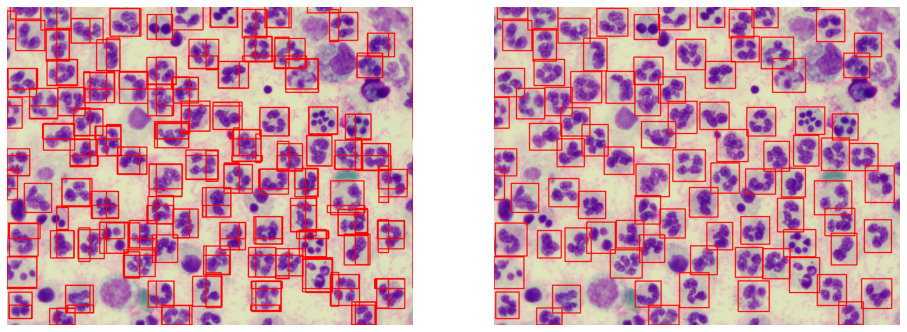

In [22]:
fig = plt.figure(figsize=(16, 8)) # width=16 height=8

ax = fig.add_subplot(1,2,1)
ax.imshow(cv2.cvtColor(image_view_without_nms, cv2.COLOR_BGR2RGB).astype("uint8"))
ax.set_axis_off()

ax = fig.add_subplot(1,2,2)
ax.imshow(cv2.cvtColor(image_view_with_nms, cv2.COLOR_BGR2RGB).astype("uint8"))
ax.set_axis_off()

### 4.2 输出结果

#### 4.1 To Labelme

In [23]:
import json
import base64

def img_base64(img_path):
    with open(img_path,"rb") as f:
        base64_str = base64.b64encode(f.read())
    return base64_str 

class Mark(object):
    
    def __init__(self, version, imagePath, imageData=None, imageShape=None):
        self.version = version
        self.flags = {}
        self.shapes = []
        self.imagePath = imagePath
        self.imageData = imageData
        self.imageHeight = imageShape[0]
        self.imageWidth = imageShape[1]
    
    def add_shape(self, shape):
        self.shapes.append(shape)
        
class Shape(object):
    
    def __init__(self, label='', group_id='', shape_type="polygon", flags=None):
        self.label = label
        self.group_id = group_id
        self.shape_type = shape_type
        self.flags = {}
        
    def set_lable(self, label):
        self.label = label
    
    def set_group_id(self, group_id):
        self.group_id = group_id
    
    def set_shape_type(self, shape_type):
        self.shape_type = shape_type
        
    def set_points(self, points):
        self.points = points

In [24]:
class_names = ['EOS', 'LYM', 'MAC', 'NEU', 'OTHER', ]

mark_content = Mark('4.4.0', 'demo.jpg', imageShape=image.shape)

filename = r'demo.json'


for class_id, x_center, y_center, width, height in labels_np:
    shape = Shape()
    shape.set_lable(class_names[int(class_id)])

    x1 = int((x_center - width / 2) * original_width)
    x1 = clip_value(x1, 0, original_width)
    
    x2 = int((x_center + width / 2) * original_width)
    x2 = clip_value(x2, 0, original_width)
    
    y1 = int((y_center - height / 2) * original_height)
    y1 = clip_value(y1, 0, original_height)
    
    y2 = int((y_center + height / 2) * original_height)
    y2 = clip_value(y2, 0, original_height)

    shape.set_points([[x1, y1],[x2, y2]])
    
    shape.set_shape_type('rectangle')
    mark_content.add_shape(shape.__dict__)

with open(filename, 'w') as f:
    json.dump(mark_content.__dict__, f, ensure_ascii=False, indent=2) 
    
